<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
以下代码为 <a href="http://mng.bz/orYv">《从零开始构建大型语言模型》</a> 一书的补充代码，作者为 <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>中文翻译和代码详细注释由Lux整理，Github下载地址：<a href="https://github.com/luxianyu">https://github.com/luxianyu</a>
    
<br>Lux的Github上还有吴恩达深度学习Pytorch版学习笔记及中文详细注释的代码下载
    
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第6章：文本分类的微调


In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.1.3
tiktoken version: 0.12.0
torch version: 2.9.0+cpu
tensorflow version: 2.20.0
pandas version: 2.2.3


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/01.webp" width=500px>

## 6.1 微调的不同类型


- 本节没有代码


- 微调语言模型的最常见方法是**指令微调（instruction-finetuning）**和**分类微调（classification finetuning）**。  
- 下图所示的**指令微调**将是下一章的主题。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/02.webp" width=500px>

- **分类微调（classification finetuning）**是本章的主题。如果你有机器学习背景，这个过程可能会让你感到熟悉 —— 它类似于训练一个卷积神经网络（CNN）来识别手写数字。  
- 在分类微调中，模型会输出若干预定义的类别标签（例如，“垃圾邮件（spam）”和“非垃圾邮件（not spam）”）。  
- 分类微调后的模型只能预测在训练中出现过的类别（例如只能判断“垃圾邮件”或“非垃圾邮件”），而**指令微调模型（instruction-finetuned model）**通常可以执行多种不同任务。  
- 我们可以将分类微调后的模型视为**高度专用的模型（specialized model）**；在实践中，创建一个专用模型往往比创建一个在多任务上都表现良好的**通用模型（generalist model）**要容易得多。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/03.webp" width=400px>

## 6.2 数据集准备


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/04.webp" width=500px>

- 本节将准备用于**分类微调（classification finetuning）**的数据集。  
- 我们将使用一个包含**垃圾短信（spam）**与**非垃圾短信（non-spam）**的文本数据集，对LLM进行微调，使其能够判断短信是否为垃圾信息。  
- 首先，我们需要下载并解压该数据集。


In [2]:
# ===============================
# 导入必要的 Python 库
# ===============================
import requests  # 用于 HTTP 下载
import zipfile   # 用于解压 ZIP 文件
import os        # 用于文件操作，如重命名
from pathlib import Path  # 提供面向对象的路径操作

# ===============================
# 定义下载和解压所需的文件路径和 URL
# ===============================
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"  
# 数据集原始下载地址
zip_path = "sms_spam_collection.zip"      # 下载到本地的 ZIP 文件名
extracted_path = "sms_spam_collection"    # 解压后的文件夹路径
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"  
# 最终目标文件（TSV 格式）

# ===============================
# 定义下载并解压数据集的函数
# ===============================
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    下载 SMS Spam Collection 数据集并解压。
    
    参数：
    - url: 数据集下载 URL
    - zip_path: 本地 ZIP 文件保存路径
    - extracted_path: 解压文件夹路径
    - data_file_path: 最终 TSV 文件路径
    """
    if data_file_path.exists():  # 检查文件是否已存在
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return  # 如果文件存在则跳过下载和解压

    # ------------------------------
    # 下载文件
    # ------------------------------
    response = requests.get(url, stream=True, timeout=60)  
    # stream=True 分块下载，timeout=60 秒防止长时间无响应
    response.raise_for_status()  # 如果 HTTP 请求失败则抛出异常
    with open(zip_path, "wb") as out_file:  # 以二进制写模式打开本地 ZIP 文件
        for chunk in response.iter_content(chunk_size=8192):  
            # 分块写入文件，每次 8192 字节
            if chunk:  # 如果当前块非空
                out_file.write(chunk)  # 写入文件

    # ------------------------------
    # 解压 ZIP 文件
    # ------------------------------
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)  # 解压到指定文件夹

    # ------------------------------
    # 重命名解压后的文件为 TSV 格式
    # ------------------------------
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)  # 添加 .tsv 后缀
    print(f"File downloaded and saved as {data_file_path}")


# ===============================
# 尝试下载和解压，若主 URL 失败则使用备用 URL
# ===============================
try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


# ===============================
# 说明：
# 原书使用 urllib.request 进行下载，但在使用 VPN 或 HTTPS 协议时可能失败
# 使用 requests 库更稳定，并支持分块下载和超时控制
# 上面的代码实现了：
# 1️ 检查文件是否已存在，避免重复下载
# 2️ 下载 ZIP 文件
# 3️ 解压 ZIP 文件到指定目录
# 4️ 重命名为带 .tsv 的文件，方便后续读取
# ===============================


File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


- 该数据集以制表符分隔的文本文件（tab-separated text file）形式保存，我们可以将其加载到 pandas DataFrame 中。


In [3]:
# ===============================
# 导入 pandas 库
# ===============================
import pandas as pd  # 用于数据处理和分析

# ===============================
# 读取 SMS Spam Collection 数据集
# ===============================
df = pd.read_csv(
    data_file_path,   # 数据文件路径，之前下载并重命名为 TSV 文件
    sep="\t",         # 数据列之间的分隔符为制表符（tab）
    header=None,      # 文件没有表头行，所以设置 header=None
    names=["Label", "Text"]  # 手动为两列命名：Label 为类别（spam 或 ham），Text 为短信内容
)

# ===============================
# 查看数据框
# ===============================
df  # 输出整个 DataFrame，用于在 Jupyter Notebook 中展示


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- 查看类别分布时，我们会发现数据中 **“ham”（即非垃圾邮件）** 的数量远多于 **“spam”（垃圾邮件）**。


In [4]:
# ===============================
# 查看标签类别的分布情况
# ===============================
# df["Label"]：取出数据框中的 "Label" 列
# .value_counts()：统计每个类别出现的次数
print(df["Label"].value_counts())


Label
ham     4825
spam     747
Name: count, dtype: int64


- 为了简化处理，并且出于教学目的我们希望使用一个较小的数据集（这样可以更快地微调 LLM），我们对数据集进行了**下采样（undersample）**，使每个类别各包含 747 个样本。  
- （除了下采样之外，还有其他几种处理类别不平衡的方法，但这些内容超出了本书的范围；你可以在 [`imbalanced-learn` 用户指南](https://imbalanced-learn.org/stable/user_guide.html) 中找到示例和更多信息。）


In [5]:
# ===============================
# 创建一个平衡的数据集（spam 与 ham 样本数量相同）
# ===============================

def create_balanced_dataset(df):
    """
    输入：
        df: 原始 pandas 数据框，包含 'Label' 和 'Text' 列
    输出：
        balanced_df: 平衡后的数据框，spam 与 ham 数量相等
    """

    # ------------------------------
    # 1️ 计算 spam 样本数量
    # ------------------------------
    # df["Label"] == "spam"：布尔索引，筛选所有 spam 样本
    # df[...].shape[0]：返回行数，即 spam 样本数
    num_spam = df[df["Label"] == "spam"].shape[0]

    # ------------------------------
    # 2️ 随机抽取等量的 ham 样本
    # ------------------------------
    # df[df["Label"] == "ham"]：筛选出所有 ham 样本
    # .sample(num_spam, random_state=123)：随机抽取与 spam 数量相同的 ham 样本
    # random_state=123：设置随机种子，保证每次抽样结果相同
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # ------------------------------
    # 3️ 合并抽样的 ham 样本和所有 spam 样本
    # ------------------------------
    # pd.concat([...])：按行合并两个数据框，形成平衡数据集
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


# 创建平衡数据集
balanced_df = create_balanced_dataset(df)

# 查看平衡后的标签分布
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


- 接下来，我们将字符串类别标签 **“ham”** 和 **“spam”** 转换为整数类别标签 0 和 1：


In [6]:
# ===============================
# 将标签从字符串转换为数值
# ===============================

# balanced_df["Label"].map({...})：
# 对 "Label" 列中的每个元素应用映射规则：
# "ham" -> 0，"spam" -> 1
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# 检查转换结果
print(balanced_df.head())
print(balanced_df["Label"].value_counts())


      Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
Label
0    747
1    747
Name: count, dtype: int64


In [7]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


- 现在我们来定义一个函数，将数据集随机划分为训练集、验证集和测试集


In [8]:
# ===============================
# 随机划分数据集为训练集、验证集和测试集
# ===============================

def random_split(df, train_frac, validation_frac):
    """
    将数据集随机划分为训练集、验证集和测试集

    参数：
    - df: pandas DataFrame，包含样本和标签
    - train_frac: float，训练集占比（0~1）
    - validation_frac: float，验证集占比（0~1）
      测试集占比由剩余部分计算：1 - train_frac - validation_frac

    返回：
    - train_df: 训练集 DataFrame
    - validation_df: 验证集 DataFrame
    - test_df: 测试集 DataFrame
    """

    # 1️ 打乱整个 DataFrame，保证样本顺序随机
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    # sample(frac=1) -> 返回原 DataFrame 的全部样本，但顺序随机
    # random_state=123 -> 固定随机种子，保证可复现
    # reset_index(drop=True) -> 重置索引，丢弃原索引

    # 2️ 计算切分索引
    train_end = int(len(df) * train_frac)                # 训练集结束索引
    validation_end = train_end + int(len(df) * validation_frac)  # 验证集结束索引

    # 3️ 根据索引切分 DataFrame
    train_df = df[:train_end]                 # 前 train_end 行作为训练集
    validation_df = df[train_end:validation_end] # 接下来的行作为验证集
    test_df = df[validation_end:]             # 剩余行作为测试集

    return train_df, validation_df, test_df


# ===============================
# 调用函数进行划分
# ===============================
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# 训练集占 70%，验证集占 10%，测试集占剩余 20%

# ===============================
# 保存 CSV 文件
# ===============================
train_df.to_csv("train.csv", index=None)         # 保存训练集
validation_df.to_csv("validation.csv", index=None)  # 保存验证集
test_df.to_csv("test.csv", index=None)           # 保存测试集


## 6.3 创建数据加载器


- 注意，短信的长度各不相同；如果我们希望将多个训练样本组合成一个批次（batch），必须选择以下两种方法之一：  
  1. 将所有消息截断（truncate）到数据集中或批次中最短消息的长度  
  2. 将所有消息填充（pad）到数据集中或批次中最长消息的长度  

- 我们选择方法 2，将所有消息填充到数据集中最长消息的长度。  
- 为此，我们使用 `<|endoftext|>` 作为填充 token，正如第 2 章所讨论的。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/06.webp" width=500px>

In [9]:
# ===============================
# 导入 tiktoken 并获取 GPT-2 编码器
# ===============================
import tiktoken

# 获取 GPT-2 默认编码器对象
tokenizer = tiktoken.get_encoding("gpt2")
# get_encoding("gpt2") -> 返回一个编码器对象，可将文本转换为 token ID

# ===============================
# 编码特殊 token "<|endoftext|>"
# ===============================
encoded_ids = tokenizer.encode(
    "<|endoftext|>",                      # 需要编码的文本
    allowed_special={"<|endoftext|>"}    # 指定这是允许的特殊 token，避免报错
)

# 打印编码结果
print(encoded_ids)
# 输出类似 [50256]，表示 "<|endoftext|>" 对应的 token ID


[50256]


- 下面的 `SpamDataset` 类会识别训练数据集中最长的序列，并将填充 token 添加到其他序列，使它们的长度与最长序列一致。


In [10]:
# ===============================
# 自定义 PyTorch Dataset 用于 Spam 分类任务
# ===============================
import torch
from torch.utils.data import Dataset
import pandas as pd

class SpamDataset(Dataset):
    """
    PyTorch Dataset 类，用于将 SMS/Spam 文本数据编码为 token ID，并返回 label。
    """
    
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        """
        初始化数据集
        
        参数：
        - csv_file: str, CSV 文件路径，文件应包含 "Text" 和 "Label" 列
        - tokenizer: tiktoken 编码器对象，用于将文本转为 token ID
        - max_length: int or None，序列最大长度，如果为 None，则自动使用最长文本长度
        - pad_token_id: int，用于 padding 的 token ID（默认 50256，对应 GPT-2 的 <|endoftext|>）
        """
        # 读取 CSV 数据
        self.data = pd.read_csv(csv_file)

        # ------------------------------
        # 预先对所有文本进行编码
        # ------------------------------
        self.encoded_texts = [
            tokenizer.encode(text)  # 将每条文本转换为 token ID 列表
            for text in self.data["Text"]
        ]

        # ------------------------------
        # 处理序列长度
        # ------------------------------
        if max_length is None:
            # 如果没有指定最大长度，使用数据集中最长文本长度
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # 如果文本长度超过 max_length，则截断
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

        # ------------------------------
        # Padding: 将每条文本补齐到 max_length
        # ------------------------------
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        """
        返回指定索引的数据样本
        
        返回值：
        - encoded: torch.LongTensor, 形状 [max_length]，文本的 token ID
        - label: torch.LongTensor, 形状 [], 文本对应的标签 (0 或 1)
        """
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        """
        返回数据集总样本数
        """
        return len(self.data)

    def _longest_encoded_length(self):
        """
        计算数据集中最长的 token ID 序列长度
        """
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # 更 pythonic 的写法：
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)


In [11]:
# ===============================
# 创建训练数据集实例
# ===============================
train_dataset = SpamDataset(
    csv_file="train.csv",  # 训练集 CSV 文件路径
    max_length=None,       # 不指定最大长度，自动使用训练集最长文本的 token 数
    tokenizer=tokenizer    # 使用 GPT-2 的 tiktoken 编码器
)

# 输出训练集中的最长序列长度（以 token 数计）
print(train_dataset.max_length)


120


- 我们还将验证集（validation set）和测试集（test set）填充到训练集中最长序列的长度。  
- 注意，对于验证集和测试集中比训练集最长序列还长的样本，`SpamDataset` 代码会通过 `encoded_text[:self.max_length]` 将其截断。  
- 这种做法完全是可选的，如果在验证集和测试集中将 `max_length=None`，同样也能很好地工作。


In [12]:
# ===============================
# 创建验证集和测试集的数据集实例
# ===============================

# 验证集
val_dataset = SpamDataset(
    csv_file="validation.csv",        # 验证集 CSV 文件路径
    max_length=train_dataset.max_length,  # 使用训练集的最长序列长度进行统一 padding/truncate
    tokenizer=tokenizer               # 使用 GPT-2 的 tiktoken 编码器
)

# 测试集
test_dataset = SpamDataset(
    csv_file="test.csv",              # 测试集 CSV 文件路径
    max_length=train_dataset.max_length,  # 同样使用训练集的最长序列长度
    tokenizer=tokenizer               # 使用 GPT-2 的 tiktoken 编码器
)


- 接下来，我们使用数据集实例化数据加载器，这与前几章创建数据加载器的方式类似


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/07.webp" width=500px>

In [13]:
# ===============================
# 使用 PyTorch DataLoader 创建批量数据迭代器
# ===============================

from torch.utils.data import DataLoader

# ------------------------------
# 配置参数
# ------------------------------
num_workers = 0        # 数据加载的子进程数量，0 表示主进程加载数据
batch_size = 8         # 每个 batch 的样本数量

# 设置随机种子，保证数据 shuffle 可复现
torch.manual_seed(123)

# ===============================
# 训练集 DataLoader
# ===============================
train_loader = DataLoader(
    dataset=train_dataset,   # 数据源为训练集
    batch_size=batch_size,   # 每个 batch 8 个样本
    shuffle=True,            # 每个 epoch 训练前打乱顺序
    num_workers=num_workers, # 数据加载子进程数量
    drop_last=True,          # 如果最后一个 batch 不满 batch_size，则丢弃
)

# ===============================
# 验证集 DataLoader
# ===============================
val_loader = DataLoader(
    dataset=val_dataset,     # 数据源为验证集
    batch_size=batch_size,   # 每个 batch 8 个样本
    num_workers=num_workers, # 数据加载子进程数量
    drop_last=False,         # 保留最后一个可能不满 batch 的 batch
)

# ===============================
# 测试集 DataLoader
# ===============================
test_loader = DataLoader(
    dataset=test_dataset,    # 数据源为测试集
    batch_size=batch_size,   # 每个 batch 8 个样本
    num_workers=num_workers, # 数据加载子进程数量
    drop_last=False,         # 保留最后一个可能不满 batch 的 batch
)

# ===============================
# 说明
# ===============================
# 1. train_loader: 用于训练，每个 epoch 打乱顺序，保证模型不会看到固定顺序。
# 2. val_loader & test_loader: 用于验证和测试，不打乱顺序，以保证评估结果稳定。
# 3. batch_size: 控制每次梯度更新使用的样本数量。
# 4. drop_last: 避免训练时最后一个不完整 batch 影响梯度计算。


- 作为验证步骤，我们遍历数据加载器（data loaders），确保每个批次（batch）包含 8 个训练样本，每个训练样本包含 120 个 token。


In [14]:
# ===============================
# 查看训练集 DataLoader 输出的维度
# ===============================

print("Train loader:")

# 遍历训练集 DataLoader 取一个 batch
for input_batch, target_batch in train_loader:
    # input_batch: shape -> (batch_size, max_length)
    # target_batch: shape -> (batch_size,)
    pass  # 此处只取最后一个 batch 作为示例

# 输出输入数据的形状
print("Input batch dimensions:", input_batch.shape)
# 输出标签数据的形状
print("Label batch dimensions", target_batch.shape)

# ===============================
# 注解说明
# ===============================
# input_batch.shape -> (batch_size, max_length)
#   - batch_size: 每个 batch 的样本数量 (本例为 8)
#   - max_length: 文本序列的长度（已 pad/truncate 到相同长度）
#
# target_batch.shape -> (batch_size,)
#   - batch_size: 每个 batch 的样本数量
#   - 每个元素为 0 或 1，表示对应文本的标签（ham 或 spam）
#
# 注意：
# - DataLoader 自动将 Dataset 返回的单个样本组合成 batch
# - input_batch 已经是 tensor 类型，无需再手动转换


Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- 最后，我们打印每个数据集中的总批次数量


In [15]:
# ===============================
# 输出每个 DataLoader 的 batch 数量
# ===============================

# len(train_loader) 返回训练集 DataLoader 中总共有多少个 batch
print(f"{len(train_loader)} training batches")

# len(val_loader) 返回验证集 DataLoader 中总共有多少个 batch
print(f"{len(val_loader)} validation batches")

# len(test_loader) 返回测试集 DataLoader 中总共有多少个 batch
print(f"{len(test_loader)} test batches")

# ===============================
# 注解说明
# ===============================
# DataLoader 会根据：
# - 数据集总样本数 (len(dataset))
# - batch_size
# - drop_last 参数
# 来计算总的 batch 数量
#
# 计算公式：
# 如果 drop_last=False:
#   batch_count = ceil(total_samples / batch_size)
# 如果 drop_last=True:
#   batch_count = floor(total_samples / batch_size)
#
# 例如：
# - train_dataset 样本数 = 1000, batch_size = 8, drop_last=True
#   -> 1000 // 8 = 125 个 batch
# - val_dataset 样本数 = 100, batch_size = 8, drop_last=False
#   -> ceil(100 / 8) = 13 个 batch


130 training batches
19 validation batches
38 test batches


## 6.4 使用预训练权重初始化模型


- 在本节中，我们初始化上一章中使用的预训练模型（pretrained model）。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/08.webp" width=500px>


In [16]:
# ===============================
# 选择要使用的 GPT 模型和输入提示
# ===============================
CHOOSE_MODEL = "gpt2-small (124M)"  # 选择模型
INPUT_PROMPT = "Every effort moves"  # 输入文本，用于后续生成示例

# ===============================
# 基础配置
# ===============================
BASE_CONFIG = {
    "vocab_size": 50257,     # 词汇表大小，GPT-2 的默认词汇量
    "context_length": 1024,  # 上下文窗口长度（最大可处理的 token 数）
    "drop_rate": 0.0,        # dropout 比例，训练中可防止过拟合
    "qkv_bias": True          # 是否在 Query/Key/Value 矩阵中添加偏置
}

# ===============================
# 模型具体参数字典
# ===============================
# 对应不同大小的 GPT-2 模型，包括嵌入维度、层数、注意力头数
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# ===============================
# 将基础配置更新为所选模型的配置
# ===============================
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
# 现在 BASE_CONFIG 包含：
# {
#     "vocab_size": 50257,
#     "context_length": 1024,
#     "drop_rate": 0.0,
#     "qkv_bias": True,
#     "emb_dim": 768,
#     "n_layers": 12,
#     "n_heads": 12
# }

# ===============================
# 检查训练数据集的最大长度是否超过模型的上下文长度
# ===============================
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)
# 如果训练数据的最大 token 数大于模型的 context_length，会抛出 AssertionError
# 提示用户重新初始化数据集，设置 max_length 不超过模型的 context_length


In [17]:
# ===============================
# 从 gpt_download 模块导入下载和加载 GPT-2 权重的函数
# ===============================
from gpt_download import download_and_load_gpt2

# ===============================
# 从 previous_chapters 模块导入自定义的 GPT 模型类及加载权重函数
# ===============================
from previous_chapters import GPTModel, load_weights_into_gpt

# 注释：
# 如果本地没有 previous_chapters.py，可以使用 llms-from-scratch 包
# 例如：
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

# ===============================
# 根据选择的模型名称提取模型大小（例如 "124M"）
# ===============================
# CHOOSE_MODEL = "gpt2-small (124M)"
# 这里使用字符串处理提取括号中的模型参数
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
# 结果: model_size = "124M"

# ===============================
# 下载并加载 GPT-2 预训练权重
# ===============================
# settings: 包含模型的配置设置，如嵌入维度、层数、注意力头等
# params: 包含模型的权重参数字典
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
# models_dir 指定模型下载保存目录，这里是当前目录下的 "gpt2" 文件夹

# ===============================
# 使用自定义 GPTModel 类初始化模型实例
# ===============================
model = GPTModel(BASE_CONFIG)
# BASE_CONFIG 包含模型的词汇表大小、上下文长度、dropout、qkv_bias 以及嵌入维度、层数、注意力头数

# ===============================
# 将下载的 GPT-2 权重加载到自定义模型中
# ===============================
load_weights_into_gpt(model, params)
# 该函数将下载的权重逐层赋值给模型，包括：
# - 位置嵌入（pos_emb）
# - 词嵌入（tok_emb）
# - 多头注意力的 Q/K/V 权重与偏置
# - 前馈网络的全连接层权重与偏置
# - 层归一化参数
# - 输出头权重与词嵌入共享

# ===============================
# 切换模型为评估模式（eval），在推理或生成文本时禁用 dropout
# ===============================
model.eval()


checkpoint: 100%|██████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 44.5kiB/s]
encoder.json: 100%|██████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 1.28MiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 24.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████████████████████████| 498M/498M [03:33<00:00, 2.33MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 2.64MiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:00<00:00, 842kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 795kiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 为确保模型正确加载，我们来再次检查它是否能够生成连贯的文本


In [18]:
# -----------------------------------------------
# 详解：从 CHOOSE_MODEL 字符串中提取模型大小（如 "124M"）
# -----------------------------------------------

# 假设 CHOOSE_MODEL = "gpt2-small (124M)"

# 1️⃣ 先用 split(" ") 按空格分割字符串：
#    CHOOSE_MODEL.split(" ") -> ["gpt2-small", "(124M)"]
#    结果是一个列表，列表最后一个元素就是我们想要的 "(124M)"
##last_element = CHOOSE_MODEL.split(" ")[-1]
# last_element = "(124M)"

# 2️⃣ 使用 lstrip("(") 去掉左侧的左括号 "("
#    "(124M)".lstrip("(") -> "124M)"
##stripped_left = last_element.lstrip("(")
# stripped_left = "124M)"

# 3️⃣ 使用 rstrip(")") 去掉右侧的右括号 ")"
#    "124M)".rstrip(")") -> "124M"
##model_size = stripped_left.rstrip(")")
# model_size = "124M"

# 🔹 最终结果：
# model_size 变量就是我们想要的 GPT-2 模型大小字符串 "124M"


In [19]:
# =======================================================
# 详解：使用 GPT-2 模型生成文本（简化版生成函数）
# =======================================================

# 导入上一章节提供的辅助函数：
# 1️ generate_text_simple：根据模型和输入 token 生成后续 token
# 2️ text_to_token_ids：将字符串文本转换为模型 token ID
# 3️ token_ids_to_text：将 token ID 转换回可读文本
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

# -------------------------------------------------------
# 1️ 准备输入文本
# -------------------------------------------------------
text_1 = "Every effort moves you"  # 待生成文本的初始上下文（prompt）

# -------------------------------------------------------
# 2️ 将文本转换为模型可处理的 token ID
# -------------------------------------------------------
# text_to_token_ids 函数会调用 GPT-2 tokenizer 将文本编码成整数 token 序列
# 例如 "Every" -> 15496, "effort" -> 12345 等
input_ids = text_to_token_ids(text_1, tokenizer)

# -------------------------------------------------------
# 3️ 使用 generate_text_simple 生成后续 token
# -------------------------------------------------------
# 参数详解：
# - model: GPT-2 模型对象
# - idx: 初始 token ID 序列
# - max_new_tokens: 生成的最大 token 数量（这里是 15）
# - context_size: 模型的上下文窗口大小（context length），决定了模型每次能看到多少历史 token
token_ids = generate_text_simple(
    model=model,
    idx=input_ids,                       # 输入的 token ID 序列
    max_new_tokens=15,                   # 最多生成 15 个新 token
    context_size=BASE_CONFIG["context_length"]  # 上下文长度
)

# -------------------------------------------------------
# 4️ 将生成的 token 序列转换回可读文本
# -------------------------------------------------------
# token_ids_to_text 会将整数 token 序列解码为字符串文本
output_text = token_ids_to_text(token_ids, tokenizer)

# 输出生成的文本
print(output_text)


Every effort moves you forward.

The first step is to understand the importance of your work


- 在将模型微调为分类器之前，让我们看看模型是否已经可以通过提示（prompting）对垃圾邮件消息进行分类


In [20]:
# =======================================================
# 详解：用 GPT-2 对短信内容进行简单“是否垃圾短信”推理生成
# =======================================================

# -------------------------------------------------------
# 1️ 准备输入文本
# -------------------------------------------------------
# 我们构造一个带指示的 prompt，要求模型判断文本是否为垃圾短信（spam）
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
# prompt 的含义：
# 1. 首句："Is the following text 'spam'? Answer with 'yes' or 'no':"
#    - 指示模型执行二分类推理任务
# 2. 第二句：短信内容
#    - 模型根据短信内容判断其是否为垃圾短信

# -------------------------------------------------------
# 2️ 将文本转换为模型 token ID
# -------------------------------------------------------
# text_to_token_ids 会将字符串转化为整数 token 序列
# 例如 "You" -> 345, "are" -> 123 等
input_ids = text_to_token_ids(text_2, tokenizer)

# -------------------------------------------------------
# 3️ 使用 generate_text_simple 生成模型回答
# -------------------------------------------------------
# 参数详解：
# - model: GPT-2 模型对象
# - idx: 初始 token ID 序列（prompt）
# - max_new_tokens: 最多生成 23 个 token（即模型回答的长度）
# - context_size: 模型上下文窗口大小（context length）
token_ids = generate_text_simple(
    model=model,
    idx=input_ids,                       # 输入 token ID
    max_new_tokens=23,                   # 最大生成 23 个 token
    context_size=BASE_CONFIG["context_length"]  # 上下文长度
)

# -------------------------------------------------------
# 4️ 将生成的 token 序列转换回可读文本
# -------------------------------------------------------
# token_ids_to_text 会将 token ID 解码为字符串
output_text = token_ids_to_text(token_ids, tokenizer)

# 输出模型生成的文本（即对垃圾短信的预测）
print(output_text)


Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- 如我们所见，模型在遵循指令方面表现不佳。  
- 这是预料之中的，因为它仅经过预训练（pretraining），尚未进行指令微调（instruction-finetuning，下一章将介绍）。


## 6.5 添加分类头（Classification Head）


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/09.webp" width=500px>

- 在本节中，我们将对预训练的 LLM 进行修改，使其可以进行分类微调（classification finetuning）。  
- 首先，让我们来看一下模型的架构。


In [21]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 上图展示了我们在第 4 章实现的模型架构，布局清晰。  
- 我们的目标是替换并微调输出层（output layer）。  
- 为此，我们首先**冻结模型（freeze the model）**，也就是将所有层设置为不可训练。


In [22]:
# =======================================================
# 详解：冻结 GPT-2 模型的所有参数
# =======================================================

# -------------------------------------------------------
# 1️ 遍历模型中所有参数
# -------------------------------------------------------
# model.parameters() 返回模型中所有可训练参数的生成器（generator）
# 每个参数（param）是一个 torch.nn.Parameter 张量，
# 包含了模型的权重矩阵或偏置项（bias）。
for param in model.parameters():
    
    # ---------------------------------------------------
    # 2️ 禁止这些参数在反向传播时被更新
    # ---------------------------------------------------
    # 每个参数都有一个属性 `requires_grad`，表示是否需要计算梯度。
    # 当 requires_grad=True 时，PyTorch 会在反向传播时计算梯度；
    # 当 requires_grad=False 时，该参数在训练时保持固定（冻结），不会被更新。
    param.requires_grad = False

# -------------------------------------------------------
# 3️ 目的与作用
# -------------------------------------------------------
# 这一步“冻结”模型所有参数，使得在后续微调（fine-tuning）过程中，
# GPT-2 的原始权重保持不变，仅允许新增的层（例如分类头）参与训练。
# 
#  优点：
#   - 避免破坏已学到的语言知识。
#   - 降低训练计算量和显存占用。
#   - 提高小样本任务（如垃圾短信分类）训练稳定性。
# 
#  典型应用：
#   - 在预训练模型上仅添加一个线性分类器（linear head）；
#   - 仅训练该分类器用于下游任务（如 spam detection）。


- 接下来，我们替换输出层（`model.out_head`），该层原本将输入映射到 50,257 维（即词汇表大小）。  
- 由于我们要对模型进行二分类微调（预测 2 个类别，“spam”和“not spam”），可以像下面这样替换输出层，该层默认是可训练的。  
- 注意，我们使用 `BASE_CONFIG["emb_dim"]`（在 `"gpt2-small (124M)"` 模型中等于 768）来使下面的代码更通用。


In [23]:
# ===========================================================
# 详解：替换 GPT 模型的输出层为二分类头（Spam / Ham）
# ===========================================================

# -----------------------------------------------------------
# 1️ 设置随机种子，确保实验结果可复现
# -----------------------------------------------------------
# 在深度学习中，某些操作（如权重初始化、数据打乱等）具有随机性。
# 通过固定随机种子，可以保证每次运行时模型初始化结果相同。
torch.manual_seed(123)


# -----------------------------------------------------------
# 2️ 定义分类任务的类别数量
# -----------------------------------------------------------
# 在垃圾短信分类任务中，我们只有两类：
#   0 → "ham"（正常短信）
#   1 → "spam"（垃圾短信）
# 因此这里设置类别数为 2。
num_classes = 2


# -----------------------------------------------------------
# 3️ 替换 GPT 模型原有的输出层（out_head）
# -----------------------------------------------------------
# 原本 GPT 的 out_head 是一个线性层，用于将隐藏向量
# 转换为词汇表中每个 token 的概率分布（输出维度 = vocab_size ≈ 50257）。
# 
# 在这里我们把它改成一个新的线性层，用于分类任务。
# 新的线性层输入特征数与 GPT 隐藏层维度一致，
# 输出特征数为类别数（2个类别）。
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],  # 输入维度（GPT 的隐藏层维度，如 768）
    out_features=num_classes              # 输出维度（分类类别数：2）
)


# -----------------------------------------------------------
# 4️ 背景知识：为什么替换输出头？
# -----------------------------------------------------------
# GPT 原设计任务是语言建模（预测下一个词），
# 所以原始输出层输出的是词汇表大小的概率分布。
# 而现在我们要将 GPT 用作文本分类器，
# 任务目标变为预测“这条短信是否为垃圾信息”，
# 因此输出头需要输出“2个数”，代表两个类别的得分。
# 
#  GPT 的主体（transformer blocks）继续作为“特征提取器”；
#  新增的 out_head 层（线性层）则作为“分类头”；
#  训练时只更新这个新层的参数，保持原 GPT 参数冻结。


- 从技术上讲，仅训练输出层就足够了。  
- 但是，正如我在 [Finetuning Large Language Models](https://magazine.sebastianraschka.com/p/finetuning-large-language-models) 中发现的，实验表明微调额外的层可以显著提升模型性能。  
- 因此，我们还将最后一个 transformer block 以及连接最后一个 transformer block 与输出层的最终 `LayerNorm` 模块设置为可训练。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/10.webp" width=500px>

In [24]:
# ===========================================================
# 详解：解冻 GPT 模型最后一层 Transformer Block 和最终归一化层
# ===========================================================

# -----------------------------------------------------------
# 1️⃣ 冻结（Freeze）与解冻（Unfreeze）的概念
# -----------------------------------------------------------
# 在迁移学习中，我们通常不从头训练整个大模型，
# 而是加载一个已经在大规模语料上预训练过的模型（如 GPT-2），
# 然后只微调（fine-tune）其中的一小部分参数。
#
# 冻结参数的操作： param.requires_grad = False
# 表示在反向传播时，这些参数不参与梯度计算，不会被更新。
#
# 解冻参数的操作： param.requires_grad = True
# 表示这些参数在训练时会被更新。
#
# 这样做的好处是：
# ✅ 节省计算资源；
# ✅ 避免破坏预训练模型学到的通用语言特征；
# ✅ 只调整模型的最后几层，使模型更好地适应当前任务（垃圾短信分类）。

# -----------------------------------------------------------
# 2️⃣ 解冻最后一个 Transformer Block
# -----------------------------------------------------------
# GPT 模型由多个 transformer block 堆叠而成（例如 GPT-2 small 有 12 层）。
# 每个 block 都包含：
#   - 自注意力层 (Self-Attention)
#   - 前馈网络层 (Feed-Forward Network)
#   - 残差连接与层归一化 (LayerNorm)
#
# 我们这里只解冻最后一层（即最靠近输出的那一层），
# 因为它离任务输出最近，对分类任务的特征学习最有帮助。
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True


# -----------------------------------------------------------
# 3️⃣ 解冻最终的归一化层（final_norm）
# -----------------------------------------------------------
# 在 GPT 模型的输出层之前，还有一个最终的 LayerNorm（final_norm）。
# 该层的作用是：
#   - 归一化最后一层 transformer 输出；
#   - 保持数值稳定；
#   - 使特征分布更加适合后续分类层。
#
# 我们解冻它，是为了允许模型对输出特征进行轻微调整，
# 从而更好地适应新的任务（垃圾短信分类）。
for param in model.final_norm.parameters():
    param.requires_grad = True


# -----------------------------------------------------------
# 4️⃣ 总结：当前参数训练策略
# -----------------------------------------------------------
# ✅ 大部分 GPT 参数（前面层）被冻结，不会更新；
# ✅ 仅以下部分会在训练中被更新：
#    1. 新添加的分类头（out_head）
#    2. 最后一层 Transformer Block（model.trf_blocks[-1]）
#    3. 最终 LayerNorm（model.final_norm）
#
# 这种方式称为 **部分微调（partial fine-tuning）**，
# 是实践中常用的技巧，用于高效适配大型语言模型到下游任务。


- 我们仍然可以像前几章一样使用该模型  
- 例如，我们给它输入一些文本


In [25]:
# ===========================================================
# 详解：将输入文本转换为 GPT 模型可处理的张量格式
# ===========================================================

# -----------------------------------------------------------
# 1️⃣ 将字符串转换为 token ID 序列
# -----------------------------------------------------------
# tokenizer.encode() 会将自然语言字符串转换为 token ID 序列。
# 在 GPT-2 中：
#   - 每个单词、标点、甚至部分单词（子词）都有唯一的整数 ID；
#   - 这些 ID 对应到模型词嵌入矩阵（embedding layer）中的向量。
#
# 例如：
#   输入文本："Do you have time"
#   输出可能是：[  437,  345,  617,  1073 ]
# （实际数字可能略有不同，取决于 tokenizer 的词表。）
inputs = tokenizer.encode("Do you have time")

# -----------------------------------------------------------
# 2️⃣ 将 token ID 列表转换为 PyTorch 张量
# -----------------------------------------------------------
# PyTorch 模型期望输入是一个张量（tensor），而不是 Python 列表。
# 因此我们使用 torch.tensor() 将其转换。
# 注意：此时得到的是一维张量，形状为 (num_tokens,)
# 即： [437, 345, 617, 1073]
inputs = torch.tensor(inputs)

# -----------------------------------------------------------
# 3️⃣ 添加 batch 维度
# -----------------------------------------------------------
# GPT 模型输入的标准形状是：
#    (batch_size, num_tokens)
# 其中：
#   - batch_size 表示一次输入的样本数量；
#   - num_tokens 表示每个样本的 token 数。
#
# 由于这里只输入一个句子（单样本），
# 我们使用 unsqueeze(0) 在最前面添加一个维度。
# 结果形状变为 (1, num_tokens)
# 示例： torch.Size([1, 4])
inputs = inputs.unsqueeze(0)

# -----------------------------------------------------------
# 4️⃣ 打印结果以验证
# -----------------------------------------------------------
print("Inputs:", inputs)                # 打印 token ID 序列张量
print("Inputs dimensions:", inputs.shape)  # 打印形状，例如 (1, 4)
# (1, num_tokens) 表示：
#   batch_size = 1
#   num_tokens = 输入文本的 token 数量


Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- 与前几章不同的是，现在输出层的维度为 2，而不是 50,257。


In [26]:
# ============================================
# 使用上下文管理器 torch.no_grad() 禁用梯度计算
# ============================================
# 说明：
# - 在 PyTorch 中，模型的前向传播（forward）通常会自动记录计算图，
#   以便在反向传播时计算梯度（即训练阶段需要的梯度更新信息）。
# - 但在这里，我们只想执行“推理”（inference），
#   即让模型对输入数据进行预测，而不进行参数更新。
# - 使用 `with torch.no_grad():` 可以临时关闭 autograd（自动求导）功能，
#   这样能显著减少内存占用并加快计算速度。
# - 常用于模型评估阶段（evaluation phase）。

with torch.no_grad():  
    # 调用模型进行前向传播（forward pass）
    # ---------------------------------------------
    # 参数说明：
    #   - model：这是我们定义好的 GPT 模型对象（GPTModel 类的实例）
    #   - inputs：输入张量，形状为 (batch_size, num_tokens)
    #              例如 (1, 4)，表示 1 条文本，共 4 个 token
    # 功能说明：
    #   - 模型会将输入 token id 序列通过嵌入层、Transformer 块、归一化层
    #     和输出层（out_head，全连接层）进行前向计算。
    #   - 由于我们之前把 `out_head` 改为 `nn.Linear(..., num_classes=2)`，
    #     因此模型的输出是每个 token 对应的“二分类结果”（spam/ham 概率分数）。
    # 返回值：
    #   - outputs：张量，维度为 (batch_size, num_tokens, num_classes)
    #               例如 (1, 4, 2)
    #               表示每个 token 都有一个长度为 2 的输出向量，
    #               分别对应“非垃圾邮件 (ham)”和“垃圾邮件 (spam)”两个类别的得分。
    outputs = model(inputs)

# ============================================
# 打印模型的原始输出张量
# ============================================
# - 这一步是为了查看模型输出的实际内容（即 logits 数值）
# - logits 通常是未经 softmax 的原始分数（实数），
#   它们稍后会通过 softmax 转化为概率分布。
# - 因为我们此时输出的是二分类任务的结果，
#   所以每个 token 会对应两个值（代表“ham”和“spam”的原始得分）。

print("Outputs:\n", outputs)

# ============================================
# 打印输出张量的维度信息
# ============================================
# - 我们通过 `.shape` 属性查看 outputs 的张量形状
# - 对于文本分类任务：
#   (batch_size, num_tokens, num_classes)
#   含义如下：
#   → batch_size：一次输入的样本数（这里为 1）
#   → num_tokens：输入序列中 token 的个数（例如 "Do you have time" 有 4 个 token）
#   → num_classes：输出类别数量（这里是 2，对应 ham/spam）
# - 这有助于验证模型的输出维度是否与任务匹配。

print("Outputs dimensions:", outputs.shape)  # shape: (batch_size, num_tokens, num_classes)


Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


- 如前几章所讨论，对于每个输入 token，模型都会输出一个向量。  
- 由于我们输入了一个包含 4 个 token 的文本样本，上图中输出由 4 个 2 维输出向量组成。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/11.webp" width=500px>

- 在第 3 章中，我们讨论了注意力机制（attention mechanism），它将每个输入 token 与其他所有输入 token 连接起来。  
- 第 3 章中还介绍了 GPT 类模型中使用的因果注意力掩码（causal attention mask）；该因果掩码使当前 token 只能关注当前位置及之前的位置。  
- 基于这种因果注意力机制，第 4 个（最后一个）token 包含了所有 token 中最多的信息，因为它是唯一一个包含了其他所有 token 信息的 token。  
- 因此，我们特别关注这个最后的 token，并将其用于垃圾短信分类任务的微调。


In [27]:
# ============================================
# 打印最后一个输出 token 对应的预测结果
# ============================================
# - 目的：从模型的输出张量中，取出每个序列的最后一个 token 的预测结果。
# - 原理：Transformer（如 GPT 模型）会为输入序列中的每个 token
#         生成一个对应的输出向量（即 logits）。
#         例如，对于输入 "Do you have time"，共有 4 个 token，
#         模型输出形状为 (1, 4, 2)：
#           → batch_size = 1
#           → num_tokens = 4
#           → num_classes = 2
#         输出示意：
#           outputs = [
#             [ [logit_1_1, logit_1_2],   # 第1个token ("Do")
#               [logit_2_1, logit_2_2],   # 第2个token ("you")
#               [logit_3_1, logit_3_2],   # 第3个token ("have")
#               [logit_4_1, logit_4_2] ]  # 第4个token ("time") ← 我们取的就是这个
#           ]
# - 因此 outputs[:, -1, :] 表示：
#   1️⃣ “ : ” 表示取所有批次样本（这里 batch_size=1）
#   2️⃣ “ -1 ” 表示取最后一个 token（Python 索引规则）
#   3️⃣ “ : ” 表示取该 token 的所有类别输出（这里是2个类别：ham/spam）

print("Last output token:", outputs[:, -1, :])
# 输出结果形状为 (batch_size, num_classes)
# 例如：tensor([[ 0.7213, -0.4527]])
# 含义：
# - 第一个值：该样本被预测为“ham”（非垃圾）的原始分数（logit）
# - 第二个值：该样本被预测为“spam”（垃圾）的原始分数（logit）
# - 这两个数通常会送入 softmax 函数，转化为概率形式，便于解释分类结果。


Last output token: tensor([[-3.5983,  3.9902]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/12.webp" width=200px>

## 6.6 计算分类损失和准确率


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/13.webp" width=300px>

- 在解释损失计算之前，我们先简要看看模型输出是如何转换为类别标签的。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/14.webp" width=600px>

In [28]:
# ==========================================================
# 打印模型输出中 “最后一个 token” 的预测结果
# ==========================================================

# 语句解析：
# outputs 是模型的前向传播输出张量（tensor），
# 它的典型形状是：
#   (batch_size, sequence_length, num_classes)
# 例如：
#   batch_size = 1         # 一次输入一句话
#   sequence_length = 4     # 句子中共有4个token
#   num_classes = 2         # 垃圾邮件分类任务中有两个类别：ham(0), spam(1)
#
# 输出示意：
# tensor([
#   [
#     [logit_Do_ham, logit_Do_spam],         # 第1个token "Do"
#     [logit_you_ham, logit_you_spam],       # 第2个token "you"
#     [logit_have_ham, logit_have_spam],     # 第3个token "have"
#     [logit_time_ham, logit_time_spam]      # 第4个token "time" ← 我们只取这个
#   ]
# ])

# ==========================================================
# outputs[:, -1, :]
# ==========================================================
# 含义详解：
#   “: ” → 取所有批次样本（因为 batch_size 可能大于1）
#   “-1” → 取序列中的最后一个 token（Python 中 -1 表示最后一个索引）
#   “:”  → 取该 token 的所有类别输出（这里是2个类别的logit值）
#
# 因此：
# outputs[:, -1, :] 的结果形状为：
#   (batch_size, num_classes)
# 例如：tensor([[ 0.7213, -0.4527]])
#
# 这两个数（logit 值）表示：
#   第1个数 → 预测为“ham”的分数（未归一化概率）
#   第2个数 → 预测为“spam”的分数（未归一化概率）
#
# GPT 类模型在文本分类任务中通常只取最后一个 token 的输出，
# 因为该位置聚合了前文全部信息（Transformer 的自注意力机制保证了这一点），
# 最后一个 token 对整个句子/消息的语义理解最完整。

print("Last output token:", outputs[:, -1, :])

# 打印出的结果为一个二维张量，例如：
# Last output token: tensor([[ 0.7213, -0.4527]])
#
# 后续通常会执行 softmax 运算，将该张量转为概率分布，
# 以便确定哪一类（ham/spam）的概率更高。


Last output token: tensor([[-3.5983,  3.9902]])


- 与第 5 章类似，我们通过 `softmax` 函数将输出（logits）转换为概率分数，然后使用 `argmax` 函数获取最大概率值对应的索引位置，从而得到类别标签。


In [29]:
# ==========================================================
# 将模型输出的 logits 转换为概率，并获得最终分类标签
# ==========================================================

# ----------------------------------------------------------
# 1️⃣ 计算类别概率分布
# ----------------------------------------------------------
# torch.softmax(input, dim)
# 参数说明：
#   - input：张量（这里是模型的输出 logits，即 outputs[:, -1, :]）
#   - dim：在哪个维度上进行 softmax 操作
#          这里 dim=-1 表示沿着“类别维度”计算概率
#
# softmax 函数定义：
#   softmax(x_i) = exp(x_i) / sum(exp(x_j))
#
# 它将任意实数向量（logits）转换为一个“概率分布”，
# 所有类别的概率加起来等于 1。
#
# 举例：
#   输入 logits = [2.0, 1.0]
#   softmax → [0.731, 0.269]
#   表示第1类概率更高。
#
# 输出张量形状：
#   probas.shape = (batch_size, num_classes)
#   例如 tensor([[0.73, 0.27]])

probas = torch.softmax(outputs[:, -1, :], dim=-1)

# ----------------------------------------------------------
# 2️⃣ 选取概率最大的类别索引
# ----------------------------------------------------------
# torch.argmax(input)
# 参数说明：
#   - input：输入张量（这里是 probas）
#   - 返回：最大值所在的索引（整数）
#
# 对于二分类任务：
#   若 argmax=0 → 预测为 “ham”（正常信息）
#   若 argmax=1 → 预测为 “spam”（垃圾信息）

label = torch.argmax(probas)

# ----------------------------------------------------------
# 3️⃣ 打印分类结果
# ----------------------------------------------------------
# .item()：将单元素张量转换为 Python 标量（int/float），
#          方便打印或后续逻辑判断。

print("Class label:", label.item())

# ----------------------------------------------------------
# ✅ 输出示例：
# ----------------------------------------------------------
# Class label: 1
#
# 若结果为 0 → ham（正常短信）
# 若结果为 1 → spam（垃圾短信）
#
# 注意：我们这里只取了一个样本（batch_size=1），
# 若是批量预测，需对 label 向量遍历或批量输出。


Class label: 1


- 注意，正如第 5 章所解释的，`softmax` 函数在这里是可选的，因为最大的输出值对应的就是最大的概率分数。


In [30]:
# ==========================================================
# 使用模型输出 logits 直接获得预测类别
# ==========================================================

# ----------------------------------------------------------
# 1️⃣ 取序列中最后一个 token 的输出 logits
# ----------------------------------------------------------
# outputs.shape = (batch_size, num_tokens, num_classes)
# - batch_size: 当前批次样本数量
# - num_tokens: 输入序列长度
# - num_classes: 分类类别数量（这里为 2：ham 或 spam）
#
# outputs[:, -1, :]：
# - ":" 表示选取所有样本
# - "-1" 表示选取序列的最后一个 token
# - ":" 表示选取最后一层输出的所有类别 logits
# 
# logits.shape = (batch_size, num_classes)
# 每个样本对应一个向量，表示该 token 对每个类别的未归一化得分（logits）

logits = outputs[:, -1, :]

# ----------------------------------------------------------
# 2️⃣ 选择最大 logits 对应的类别索引
# ----------------------------------------------------------
# torch.argmax(input)
# - input: 输入张量（这里是 logits）
# - 返回：沿指定维度最大值的索引
#   因为 logits 只有类别维度，所以默认对最后一维取最大
# 
# 返回值是 tensor 类型，形状为 (batch_size,) 或单个标量

label = torch.argmax(logits)

# ----------------------------------------------------------
# 3️⃣ 打印分类标签
# ----------------------------------------------------------
# .item()：将单元素张量转为 Python 整数或浮点数
# 在单样本情况下，可以直接打印
# 对应标签：
#   0 → ham（正常短信）
#   1 → spam（垃圾短信）

print("Class label:", label.item())

# ----------------------------------------------------------
# ✅ 总结：
# 1. 直接使用最后一个 token 的 logits（未归一化得分）进行预测
# 2. torch.argmax 选取最大值索引作为分类结果
# 3. 输出 label.item() 即最终类别


Class label: 1


- 我们可以应用这一概念来计算所谓的**分类准确率（classification accuracy）**，它计算给定数据集中正确预测的百分比。  
- 要计算分类准确率，我们可以将前面基于 `argmax` 的预测代码应用于数据集中的所有示例，并按如下方式计算正确预测的比例：


In [31]:
# ==========================================================
# 计算数据加载器上模型的分类准确率
# ==========================================================
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    计算模型在给定数据加载器上的分类准确率

    参数：
    - data_loader: torch.utils.data.DataLoader
        经过封装的输入数据加载器，返回 (input_batch, target_batch)
    - model: nn.Module
        待评估的 PyTorch 模型
    - device: torch.device
        设备信息，例如 'cpu' 或 'cuda'
    - num_batches: int 或 None
        限制计算的批次数量。None 表示使用全部批次。

    返回：
    - accuracy: float
        模型在给定数据加载器上的分类准确率
    """
    
    # ------------------------------------------------------
    # 1️⃣ 设置模型为评估模式
    # ------------------------------------------------------
    # model.eval() 会关闭 Dropout 和 BatchNorm 等训练专用层
    # 在评估或推理阶段必须设置
    model.eval()
    
    # ------------------------------------------------------
    # 2️⃣ 初始化统计量
    # ------------------------------------------------------
    correct_predictions = 0  # 正确预测样本数
    num_examples = 0          # 总样本数
    
    # ------------------------------------------------------
    # 3️⃣ 确定使用的批次数
    # ------------------------------------------------------
    if num_batches is None:
        num_batches = len(data_loader)  # 使用全部批次
    else:
        # 如果指定了 num_batches，则取最小值避免越界
        num_batches = min(num_batches, len(data_loader))
    
    # ------------------------------------------------------
    # 4️⃣ 遍历数据加载器批次
    # ------------------------------------------------------
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # -----------------------------
            # 4.1 将数据移动到指定设备
            # -----------------------------
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            
            # -----------------------------
            # 4.2 前向推理，关闭梯度计算
            # -----------------------------
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  
                # outputs.shape = (batch_size, seq_len, num_classes)
                # 选择最后一个 token 的输出 logits
                # logits.shape = (batch_size, num_classes)
            
            # -----------------------------
            # 4.3 预测类别
            # -----------------------------
            predicted_labels = torch.argmax(logits, dim=-1)
            # 对 logits 在最后一维取最大值的索引，得到预测类别
            # predicted_labels.shape = (batch_size,)
            
            # -----------------------------
            # 4.4 累加样本总数和正确预测数
            # -----------------------------
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break  # 超过指定批次数则停止
    
    # ------------------------------------------------------
    # 5️⃣ 计算并返回准确率
    # ------------------------------------------------------
    accuracy = correct_predictions / num_examples
    return accuracy


- 让我们应用该函数来计算不同数据集的分类准确率：


In [32]:
# ==========================================================
# 设备设置与模型评估示例
# ==========================================================

# ----------------------------------------------------------
# 1️⃣ 选择设备（CPU 或 GPU）
# ----------------------------------------------------------
# 如果有 GPU 可用，则使用 GPU，否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意：
# 以下是可选设置，用于在 Apple Silicon（M1/M2/M3）上使用 MPS 加速
# 在 PyTorch 2.4 下，CPU 与 MPS 的结果基本一致
# 但在早期版本可能略有差异
# if torch.cuda.is_available():
#     device = torch.device("cuda")     # 优先使用 CUDA GPU
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")      # Apple Silicon GPU 加速
# else:
#     device = torch.device("cpu")      # 默认 CPU
# print(f"Running on {device} device.")

# ----------------------------------------------------------
# 2️⃣ 将模型移动到指定设备
# ----------------------------------------------------------
# 对于 nn.Module 对象，直接 model.to(device) 即可，无需重新赋值
model.to(device)

# ----------------------------------------------------------
# 3️⃣ 设置随机种子以保证可复现性
# ----------------------------------------------------------
# PyTorch 的 DataLoader 在 shuffle=True 时会打乱数据顺序
# 设置随机种子可以保证每次实验的数据顺序一致
torch.manual_seed(123)

# ----------------------------------------------------------
# 4️⃣ 计算模型在不同数据集上的准确率
# ----------------------------------------------------------
# 这里仅取前 10 个批次进行快速评估
train_accuracy = calc_accuracy_loader(
    data_loader=train_loader,  # 训练集数据加载器
    model=model,               # 待评估模型
    device=device,             # 运行设备
    num_batches=10             # 限制计算前 10 个批次
)

val_accuracy = calc_accuracy_loader(
    data_loader=val_loader, 
    model=model, 
    device=device, 
    num_batches=10
)

test_accuracy = calc_accuracy_loader(
    data_loader=test_loader, 
    model=model, 
    device=device, 
    num_batches=10
)

# ----------------------------------------------------------
# 5️⃣ 输出结果
# ----------------------------------------------------------
# 将准确率乘以 100 转换为百分比，并保留两位小数
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- 正如我们所见，预测准确率并不高，因为我们尚未对模型进行微调


- 在开始微调（finetuning）/训练之前，我们首先需要定义训练过程中要优化的损失函数。  
- 我们的目标是最大化模型的垃圾短信分类准确率；然而，分类准确率并不是一个可微函数。  
- 因此，我们改为最小化交叉熵损失（cross-entropy loss），作为最大化分类准确率的代理（你可以在我免费提供的 [Introduction to Deep Learning](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression) 第 8 讲中了解更多相关内容）。

- `calc_loss_batch` 函数与第 5 章相同，只是我们这里只关注优化最后一个 token `model(input_batch)[:, -1, :]`，而不是所有 token `model(input_batch)`。


In [33]:
# ==========================================================
# 计算单个批次的交叉熵损失函数
# ==========================================================
def calc_loss_batch(input_batch, target_batch, model, device):
    """
    计算一个批次（batch）的模型损失（交叉熵）。

    参数：
    - input_batch: torch.Tensor, 输入序列张量，形状为 (batch_size, seq_len)
    - target_batch: torch.Tensor, 对应的目标标签，形状为 (batch_size,)
    - model: nn.Module, 待训练或评估的模型
    - device: torch.device, 计算设备（CPU 或 GPU）

    返回：
    - loss: torch.Tensor, 当前批次的平均交叉熵损失
    """

    # -----------------------------
    # 1️⃣ 将输入与目标移动到指定设备
    # -----------------------------
    # 保证输入数据与模型权重在同一设备上进行计算
    input_batch = input_batch.to(device)      # 将输入序列移动到 device
    target_batch = target_batch.to(device)    # 将目标标签移动到 device

    # -----------------------------
    # 2️⃣ 模型前向计算
    # -----------------------------
    # 输出 logits 的形状为 (batch_size, seq_len, num_classes)
    logits = model(input_batch)

    # 只取序列中最后一个 token 的 logits 作为分类输出
    # 形状变为 (batch_size, num_classes)
    logits = logits[:, -1, :]

    # -----------------------------
    # 3️⃣ 计算交叉熵损失
    # -----------------------------
    # torch.nn.functional.cross_entropy() 接受：
    # - input: 模型输出 logits，形状 (batch_size, num_classes)
    # - target: 真实标签，形状 (batch_size,)
    # 返回值为当前批次的平均损失（标量）
    loss = torch.nn.functional.cross_entropy(logits, target_batch)

    # -----------------------------
    # 4️⃣ 返回损失
    # -----------------------------
    return loss


- `calc_loss_loader` 函数与第 5 章完全相同。


In [34]:
# ==========================================================
# 计算整个数据加载器 (DataLoader) 上的平均损失
# ==========================================================
def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    计算整个数据集或部分数据集（由 DataLoader 提供）上的平均损失。

    参数：
    - data_loader: torch.utils.data.DataLoader, 提供输入和目标批次
    - model: nn.Module, 待训练或评估的模型
    - device: torch.device, 计算设备（CPU 或 GPU）
    - num_batches: int 或 None, 计算损失的批次数。None 表示使用整个数据集

    返回：
    - avg_loss: float, 数据集或指定批次的平均损失
    """

    # -----------------------------
    # 1️⃣ 初始化总损失
    # -----------------------------
    total_loss = 0.0  # 累积每个批次的损失

    # -----------------------------
    # 2️⃣ 特殊情况处理
    # -----------------------------
    if len(data_loader) == 0:
        # 如果数据加载器为空，返回 NaN
        return float("nan")
    elif num_batches is None:
        # 如果未指定批次数，则使用 DataLoader 的全部批次
        num_batches = len(data_loader)
    else:
        # 如果指定了批次数，但超过了 DataLoader 的总批次，则取最小值
        num_batches = min(num_batches, len(data_loader))

    # -----------------------------
    # 3️⃣ 遍历每个批次计算损失
    # -----------------------------
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # 计算当前批次的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 累加标量损失
            total_loss += loss.item()
        else:
            # 超过指定批次数，提前结束循环
            break

    # -----------------------------
    # 4️⃣ 返回平均损失
    # -----------------------------
    avg_loss = total_loss / num_batches  # 计算每个批次的平均损失
    return avg_loss


- 使用 `calc_loss_loader`，我们可以在开始训练之前计算初始的训练集、验证集和测试集损失。


In [35]:
# ==========================================================
# 在不计算梯度的情况下计算训练/验证/测试集的平均损失
# ==========================================================
with torch.no_grad():  # 关闭梯度计算，提高推理效率，因为当前不是训练阶段

    # -----------------------------
    # 1️⃣ 计算训练集损失
    # -----------------------------
    train_loss = calc_loss_loader(
        data_loader=train_loader,  # 提供训练数据的 DataLoader
        model=model,               # 参与计算的模型
        device=device,             # 计算设备（CPU 或 GPU）
        num_batches=5              # 仅计算前 5 个批次，快速估计
    )

    # -----------------------------
    # 2️⃣ 计算验证集损失
    # -----------------------------
    val_loss = calc_loss_loader(
        data_loader=val_loader,    # 提供验证数据的 DataLoader
        model=model,
        device=device,
        num_batches=5              # 仅计算前 5 个批次
    )

    # -----------------------------
    # 3️⃣ 计算测试集损失
    # -----------------------------
    test_loss = calc_loss_loader(
        data_loader=test_loader,   # 提供测试数据的 DataLoader
        model=model,
        device=device,
        num_batches=5              # 仅计算前 5 个批次
    )

# -----------------------------
# 4️⃣ 打印损失
# -----------------------------
print(f"Training loss: {train_loss:.3f}")  # 显示训练集平均损失，保留 3 位小数
print(f"Validation loss: {val_loss:.3f}") # 显示验证集平均损失
print(f"Test loss: {test_loss:.3f}")      # 显示测试集平均损失


Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


- 在下一节中，我们将训练模型，以提高损失值表现，从而提升分类准确率


## 6.7 在有监督数据上微调模型


- 在本节中，我们定义并使用训练函数来提高模型的分类准确率。  
- 下面的 `train_classifier_simple` 函数实际上与第 5 章中用于预训练模型的 `train_model_simple` 函数几乎相同。  
- 唯一的两个区别是：  
  1. 我们现在跟踪的是已见训练样本数量（`examples_seen`），而不是已见 token 数量。  
  2. 我们在每个 epoch 后计算准确率，而不是在每个 epoch 后打印示例文本。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/15.webp" width=500px>

In [36]:
# ==========================================================
# 简化版分类器训练函数，类似第5章的 train_model_simple
# ==========================================================
def train_classifier_simple(
        model,         # nn.Module 类，待训练的分类模型
        train_loader,  # 训练数据的 DataLoader
        val_loader,    # 验证数据的 DataLoader
        optimizer,     # 优化器，例如 torch.optim.AdamW
        device,        # 计算设备（CPU 或 GPU）
        num_epochs,    # 总训练轮数
        eval_freq,     # 每隔多少步（batch）进行一次评估
        eval_iter      # 评估时使用的 batch 数量
    ):

    # -----------------------------
    # 1️⃣ 初始化记录变量
    # -----------------------------
    train_losses, val_losses = [], []  # 保存每次评估的训练/验证损失
    train_accs, val_accs = [], []      # 保存每次评估的训练/验证准确率
    examples_seen, global_step = 0, -1 # 总样本数计数 & 全局训练步数

    # -----------------------------
    # 2️⃣ 主训练循环：遍历每一轮 epoch
    # -----------------------------
    for epoch in range(num_epochs):
        model.train()  # 切换模型为训练模式，启用 dropout 和 batch norm 等

        # -----------------------------
        # 2a️⃣ 遍历训练数据 loader 中的每一个批次
        # -----------------------------
        for input_batch, target_batch in train_loader:
            
            optimizer.zero_grad()  # 清零上一批次梯度，防止梯度累加

            # 计算当前批次的损失
            loss = calc_loss_batch(
                input_batch,   # 当前批次输入张量 (batch_size, seq_len)
                target_batch,  # 当前批次标签张量 (batch_size)
                model,         # 模型
                device         # 设备
            )

            loss.backward()  # 反向传播计算梯度

            optimizer.step()  # 根据梯度更新模型权重

            # -----------------------------
            # 2b️⃣ 更新计数器
            # -----------------------------
            examples_seen += input_batch.shape[0]  # 累计训练样本数
            global_step += 1                        # 全局训练步数 +1

            # -----------------------------
            # 2c️⃣ 可选评估：每 eval_freq 步进行一次损失评估
            # -----------------------------
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,       # 当前训练模型
                    train_loader, # 训练数据 loader
                    val_loader,   # 验证数据 loader
                    device,       # 计算设备
                    eval_iter     # 评估时使用的 batch 数量
                )
                train_losses.append(train_loss)  # 保存训练损失
                val_losses.append(val_loss)      # 保存验证损失

                # 输出当前步的训练/验证损失信息
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # -----------------------------
        # 3️⃣ 每轮结束后计算训练集 & 验证集准确率
        # -----------------------------
        train_accuracy = calc_accuracy_loader(
            train_loader,  # 训练数据 loader
            model,         # 模型
            device,        # 设备
            num_batches=eval_iter # 只用前 eval_iter 个 batch 快速估计准确率
        )
        val_accuracy = calc_accuracy_loader(
            val_loader,    # 验证数据 loader
            model,
            device,
            num_batches=eval_iter
        )

        # 打印训练集与验证集准确率
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        # 保存本轮准确率
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    # -----------------------------
    # 4️⃣ 返回训练记录
    # -----------------------------
    return train_losses, val_losses, train_accs, val_accs, examples_seen


- 在 `train_classifier_simple` 中使用的 `evaluate_model` 函数与第5章中使用的函数相同


In [38]:
# ==========================================================
# 评估模型在训练集和验证集上的平均损失
# ==========================================================

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    在训练和验证数据上计算平均交叉熵损失，用于训练过程中监控模型性能。
    
    参数:
        model (nn.Module): 待评估的模型
        train_loader (DataLoader): 训练数据加载器
        val_loader (DataLoader): 验证数据加载器
        device (torch.device): 计算设备（CPU 或 GPU）
        eval_iter (int): 用于快速评估的 batch 数量
        
    返回:
        train_loss (float): 前 eval_iter 个训练 batch 的平均损失
        val_loss (float): 前 eval_iter 个验证 batch 的平均损失
    """
    
    # -----------------------------
    # 1️⃣ 切换模型为评估模式
    # -----------------------------
    # 评估模式下，模型禁用 Dropout、BatchNorm 等训练专用层行为
    model.eval()
    
    # -----------------------------
    # 2️⃣ 禁用梯度计算
    # -----------------------------
    # 使用 torch.no_grad() 可以节省显存和计算量，因为评估阶段不需要反向传播
    with torch.no_grad():
        # -----------------------------
        # 2a️⃣ 计算训练集前 eval_iter 个 batch 的平均损失
        # -----------------------------
        train_loss = calc_loss_loader(
            data_loader=train_loader,  # 训练数据
            model=model,               # 当前模型
            device=device,             # 计算设备
            num_batches=eval_iter      # 仅取前 eval_iter 个 batch
        )
        
        # -----------------------------
        # 2b️⃣ 计算验证集前 eval_iter 个 batch 的平均损失
        # -----------------------------
        val_loss = calc_loss_loader(
            data_loader=val_loader,    # 验证数据
            model=model,               # 当前模型
            device=device,             # 计算设备
            num_batches=eval_iter      # 仅取前 eval_iter 个 batch
        )
    
    # -----------------------------
    # 3️⃣ 恢复模型训练模式
    # -----------------------------
    # 在训练循环中继续训练时，需要恢复 Dropout 等训练行为
    model.train()
    
    # -----------------------------
    # 4️⃣ 返回训练集和验证集的平均损失
    # -----------------------------
    return train_loss, val_loss


- 在 M3 MacBook Air 笔记本电脑上训练大约需要 5 分钟，在 V100 或 A100 GPU 上训练不到半分钟


In [ ]:
# ==========================================================
# 训练分类器并记录时间
# ==========================================================

import time  # 导入时间模块，用于计算训练耗时

# -----------------------------
# 1️⃣ 记录训练开始时间
# -----------------------------
start_time = time.time()  # 返回当前时间戳（秒）

# -----------------------------
# 2️⃣ 设置随机种子，保证训练可复现
# -----------------------------
torch.manual_seed(123)  # 对 CPU & GPU 的随机操作都生效

# -----------------------------
# 3️⃣ 初始化优化器
# -----------------------------
optimizer = torch.optim.AdamW(
    model.parameters(),  # 待优化的模型参数
    lr=5e-5,             # 学习率，控制每次梯度更新幅度
    weight_decay=0.1     # 权重衰减（L2 正则化），防止过拟合
)

# -----------------------------
# 4️⃣ 设置训练轮数
# -----------------------------
num_epochs = 5  # 总训练轮数

# -----------------------------
# 5️⃣ 调用训练函数，开始训练
# -----------------------------
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model,         # 待训练模型
    train_loader,  # 训练数据 DataLoader
    val_loader,    # 验证数据 DataLoader
    optimizer,     # 优化器
    device,        # 计算设备（CPU 或 GPU）
    num_epochs=num_epochs,  # 总训练轮数
    eval_freq=50,           # 每 50 个 batch 进行一次训练/验证损失评估
    eval_iter=5,            # 每次评估只使用前 5 个 batch（快速估计）
)

# -----------------------------
# 6️⃣ 记录训练结束时间
# -----------------------------
end_time = time.time()  # 返回训练结束时的时间戳（秒）

# -----------------------------
# 7️⃣ 计算训练耗时（分钟）
# -----------------------------
execution_time_minutes = (end_time - start_time) / 60  # 秒转分钟
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 1.977, Val loss 2.196
Ep 1 (Step 000050): Train loss 0.615, Val loss 0.636
Ep 1 (Step 000100): Train loss 0.520, Val loss 0.555
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.563, Val loss 0.488
Ep 2 (Step 000200): Train loss 0.418, Val loss 0.395
Ep 2 (Step 000250): Train loss 0.408, Val loss 0.352
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.330, Val loss 0.314
Ep 3 (Step 000350): Train loss 0.278, Val loss 0.181
Training accuracy: 90.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.076, Val loss 0.131
Ep 4 (Step 000450): Train loss 0.125, Val loss 0.099
Ep 4 (Step 000500): Train loss 0.202, Val loss 0.102
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.206, Val loss 0.110


- 类似于第5章，我们使用 matplotlib 绘制训练集和验证集的损失函数曲线


In [39]:
# ==========================================================
# 绘制训练与验证的损失或其他指标随训练过程变化的曲线
# ==========================================================
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    """
    绘制训练与验证曲线，并在同一图中显示 x 轴为 Epochs 和示例数。
    
    参数:
        epochs_seen (list 或 Tensor): 每次评估时对应的训练轮数 (epoch)
        examples_seen (list 或 Tensor): 每次评估时对应的累计训练样本数
        train_values (list 或 Tensor): 训练指标值，例如 loss 或 accuracy
        val_values (list 或 Tensor): 验证指标值，例如 loss 或 accuracy
        label (str, optional): y 轴标签，默认为 "loss"
    """
    
    # -----------------------------
    # 1️⃣ 创建画布和子图
    # -----------------------------
    # figsize=(5, 3) 指定图像宽 5 英寸，高 3 英寸
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # -----------------------------
    # 2️⃣ 绘制训练集和验证集曲线
    # -----------------------------
    # ax1.plot: 绘制训练指标随 epoch 的变化
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")  # 训练集曲线
    # ax1.plot: 绘制验证指标随 epoch 的变化，linestyle="-." 为点划线
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")  # 验证集曲线
    
    # 设置 x 轴和 y 轴标签
    ax1.set_xlabel("Epochs")            # x 轴为训练轮数
    ax1.set_ylabel(label.capitalize())  # y 轴为指标值，并首字母大写
    
    # 显示图例
    ax1.legend()
    
    # -----------------------------
    # 3️⃣ 创建第二个 x 轴用于显示累计样本数
    # -----------------------------
    # twiny() 创建共享 y 轴的第二个 x 轴
    ax2 = ax1.twiny()
    
    # 为了让刻度对齐，绘制一条不可见曲线
    # alpha=0 表示透明
    ax2.plot(examples_seen, train_values, alpha=0)
    
    # 设置第二个 x 轴的标签
    ax2.set_xlabel("Examples seen")
    
    # -----------------------------
    # 4️⃣ 调整布局并保存显示
    # -----------------------------
    fig.tight_layout()                # 自动调整子图参数，使图像不重叠
    plt.savefig(f"{label}-plot.pdf")  # 保存为 PDF 文件，文件名根据 label 动态生成
    plt.show()                        # 在 Jupyter Notebook 中显示图像


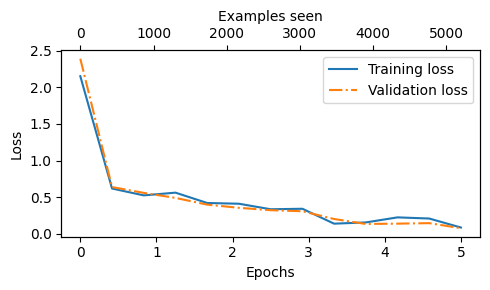

In [40]:
# ==========================================================
# 使用 plot_values 绘制训练损失曲线
# ==========================================================

# ---------------------------------------
# 1️⃣ 创建 x 轴数据：训练轮数对应的 tensor
# ---------------------------------------
# torch.linspace(start, end, steps)
# 生成一个从 start 到 end 的等间距 tensor，共 steps 个点
# 这里 len(train_losses) 个点对应每次记录的训练损失
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# 说明：epochs_tensor 中每个值表示训练过程中每次记录 loss 时对应的训练轮数

# ---------------------------------------
# 2️⃣ 创建第二个 x 轴数据：累计训练样本数
# ---------------------------------------
# 同样使用 torch.linspace 生成等间距 tensor
# 从 0 到 examples_seen，共 len(train_losses) 个点
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
# 说明：每个点对应训练过程中累计处理的样本数，方便在双 x 轴上显示

# ---------------------------------------
# 3️⃣ 调用自定义的 plot_values 函数绘图
# ---------------------------------------
# 参数解释：
# - epochs_tensor: 第一个 x 轴，表示训练轮数
# - examples_seen_tensor: 第二个 x 轴，表示累计样本数
# - train_losses: y 轴，训练损失值
# - val_losses: y 轴，验证损失值
plot_values(
    epochs_seen=epochs_tensor,        # 第一 x 轴：训练轮数
    examples_seen=examples_seen_tensor, # 第二 x 轴：累计样本数
    train_values=train_losses,        # 训练集指标值
    val_values=val_losses             # 验证集指标值
)


- 从上图的下降趋势可以看出，模型学习效果良好。  
- 此外，训练损失和验证损失非常接近，表明模型不易过拟合训练数据。  
- 同样，我们可以绘制下面的准确率曲线。


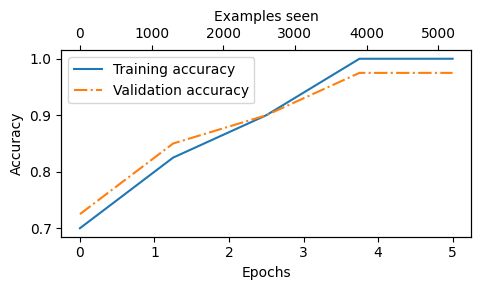

In [41]:
# ==========================================================
# 绘制训练和验证准确率曲线
# ==========================================================

# ---------------------------------------
# 1️⃣ 创建 x 轴数据：训练轮数对应的 tensor
# ---------------------------------------
# torch.linspace(start, end, steps)
# 生成一个从 start 到 end 的等间距 tensor，共 steps 个点
# 这里 len(train_accs) 个点对应每次记录的训练准确率
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
# 说明：每个点表示训练过程中记录准确率时的训练轮数

# ---------------------------------------
# 2️⃣ 创建第二个 x 轴数据：累计训练样本数
# ---------------------------------------
# 同样使用 torch.linspace 生成等间距 tensor
# 从 0 到 examples_seen，共 len(train_accs) 个点
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
# 说明：每个点对应训练过程中累计处理的样本数，方便在双 x 轴上显示

# ---------------------------------------
# 3️⃣ 调用自定义的 plot_values 函数绘图
# ---------------------------------------
# 参数解释：
# - epochs_tensor: 第一个 x 轴，表示训练轮数
# - examples_seen_tensor: 第二个 x 轴，表示累计样本数
# - train_accs: y 轴，训练准确率
# - val_accs: y 轴，验证准确率
# - label="accuracy": 用于修改 y 轴标签和图例
plot_values(
    epochs_seen=epochs_tensor,          # 第一 x 轴：训练轮数
    examples_seen=examples_seen_tensor, # 第二 x 轴：累计样本数
    train_values=train_accs,            # 训练集准确率
    val_values=val_accs,                # 验证集准确率
    label="accuracy"                    # y 轴标签显示为 accuracy
)


- 根据上图的准确率曲线，我们可以看到模型在第 4 和第 5 个 epoch 后达到了相对较高的训练和验证准确率。  
- 但是，我们必须注意，之前在训练函数中指定了 `eval_iter=5`，这意味着我们只是估算了训练集和验证集的表现。  
- 我们可以按照下面的方法计算整个数据集上的训练、验证和测试集性能。


In [40]:
# ==========================================================
# 计算训练集、验证集和测试集准确率
# ==========================================================
# 1️⃣ 调用自定义函数 calc_accuracy_loader 计算训练集准确率
# 参数说明：
# - train_loader: 数据加载器（DataLoader），提供训练批次
# - model: 当前训练或微调的模型（nn.Module）
# - device: 运行设备（CPU 或 GPU）
train_accuracy = calc_accuracy_loader(train_loader, model, device)
# 计算结果是一个 0~1 之间的小数，表示预测正确的样本比例

# 2️⃣ 调用 calc_accuracy_loader 计算验证集准确率
val_accuracy = calc_accuracy_loader(val_loader, model, device)
# 用于监控模型在未见过数据上的性能

# 3️⃣ 调用 calc_accuracy_loader 计算测试集准确率
test_accuracy = calc_accuracy_loader(test_loader, model, device)
# 测试集一般是最终评估模型的指标，不能用于训练

# ---------------------------------------
# 4️⃣ 输出结果
# ---------------------------------------
# f-string 格式化：
# - {train_accuracy*100:.2f}%: 将小数转为百分比形式，保留两位小数
# - 输出类似 "Training accuracy: 95.12%"
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 97.60%
Validation accuracy: 97.32%
Test accuracy: 96.00%


- 我们可以看到训练集和验证集的性能几乎完全一致。  
- 然而，根据测试集性能略低的情况，可以发现模型对训练数据以及用于调整部分超参数（例如学习率）的验证数据存在轻微过拟合。  
- 不过，这是正常现象，这种差距有可能通过增加模型的 dropout 率（`drop_rate`）或优化器设置中的 `weight_decay` 来进一步缩小。


## 6.8 将大型语言模型（LLM）用作垃圾邮件分类器


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/18.webp" width=500px>

- 最后，让我们实际使用微调后的 GPT 模型。  
- 下面的 `classify_review` 函数实现了与之前 `SpamDataset` 类似的数据预处理步骤。  
- 接着，该函数会返回模型预测的整数类别标签，并返回对应的类别名称。


In [41]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    """
    使用微调后的 GPT 分类器对单条文本进行垃圾邮件分类。

    参数：
    - text (str): 待分类的文本字符串
    - model (nn.Module): 微调后的 GPT 模型
    - tokenizer: 分词器，用于将文本编码成 token ids
    - device (torch.device): 运行设备（CPU 或 GPU）
    - max_length (int, optional): 输入文本的最大长度（超过截断）
    - pad_token_id (int, default=50256): 用于补齐序列的 token ID

    返回：
    - "spam" 或 "not spam" 字符串
    """

    # -------------------------
    # 1️⃣ 将模型切换到评估模式
    #    - 禁用 Dropout 和其他训练特定行为
    model.eval()

    # -------------------------
    # 2️⃣ 将文本编码成 token id 序列
    input_ids = tokenizer.encode(text)  # 返回一个整数列表，每个整数对应一个词/子词

    # -------------------------
    # 3️⃣ 获取模型支持的最大上下文长度
    #    - pos_emb.weight.shape[0] 对应 GPT 模型的位置嵌入长度，也就是 context length
    supported_context_length = model.pos_emb.weight.shape[0]
    # 注意：
    # - 在书中曾错误使用 shape[1]，结果没报错，但可能导致不必要的截断

    # -------------------------
    # 4️⃣ 截断文本序列，保证不超过 max_length 和模型支持的 context length
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # -------------------------
    # 5️⃣ 参数校验
    assert max_length is not None, (
        "必须指定 max_length。如果希望使用模型全上下文长度，"
        "请传入 max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) 超过模型最大支持的上下文长度 ({supported_context_length})"
    )

    # -------------------------
    # 6️⃣ 补齐序列到 max_length
    #    - 使用 pad_token_id 补齐不足的长度
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    # -------------------------
    # 7️⃣ 转换为张量，并增加 batch 维度
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    # 结果 shape: (1, max_length)

    # -------------------------
    # 8️⃣ 模型前向推理
    with torch.no_grad():  # 禁用梯度计算，提高推理效率
        logits = model(input_tensor)[:, -1, :]  # 取最后一个 token 的 logits
        # logits shape: (1, num_classes)

    # -------------------------
    # 9️⃣ 获取预测类别
    predicted_label = torch.argmax(logits, dim=-1).item()
    # predicted_label: 0 或 1
    # 0 -> not spam, 1 -> spam

    # -------------------------
    # 10️⃣ 返回可读的分类结果
    return "spam" if predicted_label == 1 else "not spam"


- 让我们在下面几个示例上试用该函数。


In [42]:
# -------------------------
# 1️⃣ 定义要分类的文本
#    - 这里是一条典型的垃圾短信示例
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

# -------------------------
# 2️⃣ 调用 classify_review 函数进行分类
# 参数说明：
# - text_1: 待分类文本
# - model: 微调后的 GPT 分类器模型
# - tokenizer: GPT 使用的分词器，将文本转换为 token id
# - device: 运行设备（CPU 或 GPU）
# - max_length: 输入文本的最大长度，这里使用训练数据集的最大长度
predicted_label = classify_review(
    text_1,
    model,
    tokenizer,
    device,
    max_length=train_dataset.max_length
)

# -------------------------
# 3️⃣ 输出分类结果
print(predicted_label)
# 输出示例：
# "spam" -> 表示模型认为这是垃圾短信
# "not spam" -> 表示模型认为这不是垃圾短信


spam


In [43]:
# -------------------------
# 1️⃣ 定义要分类的文本
#    - 这里是一条普通短信示例，不含垃圾信息
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

# -------------------------
# 2️⃣ 调用 classify_review 函数进行分类
# 参数说明：
# - text_2: 待分类文本
# - model: 微调后的 GPT 分类器模型
# - tokenizer: GPT 使用的分词器，用于将文本转为 token id
# - device: 运行设备（CPU 或 GPU）
# - max_length: 输入文本的最大长度，这里使用训练集的最大长度
predicted_label = classify_review(
    text_2,
    model,
    tokenizer,
    device,
    max_length=train_dataset.max_length
)

# -------------------------
# 3️⃣ 输出分类结果
print(predicted_label)
# 输出示例：
# "spam" -> 表示模型认为这是垃圾短信
# "not spam" -> 表示模型认为这不是垃圾短信


not spam


- 最后，让我们保存模型，以便以后在不重新训练的情况下重复使用。


In [44]:
# -------------------------
# 1️⃣ 保存模型权重
# torch.save() 是 PyTorch 用于保存对象的函数
# model.state_dict() 返回模型的状态字典（state dict），
#    包含模型的所有可学习参数（权重和偏置），不包含模型结构
# "review_classifier.pth" 是保存文件的路径和名称
torch.save(model.state_dict(), "review_classifier.pth")

# -------------------------
# 2️⃣ 注释说明
# - state_dict: 一个 Python 字典，key 是参数名称，value 是对应的张量
# - 仅保存 state_dict 而不保存整个模型对象有以下优点：
#    1. 文件更小
#    2. 加载时可以灵活地在相同结构的模型中重用权重
#    3. 避免因代码修改导致的模型对象不兼容问题
# - 使用方法示例：
#   model = GPTModel(BASE_CONFIG)      # 先定义模型结构
#   model.load_state_dict(torch.load("review_classifier.pth"))  # 加载权重
#   model.eval()                        # 切换到评估模式


- 然后，在新的会话中，我们可以按如下方式加载模型：


In [45]:
# -------------------------
# 1️⃣ 加载已保存的模型权重
# torch.load() 用于加载 PyTorch 保存的对象（这里是 state_dict）
# map_location=device 表示将权重映射到指定设备（CPU 或 GPU）
# 注意：torch.load 没有 weights_only 参数，因此不要加
model_state_dict = torch.load("review_classifier.pth", map_location=device)

# -------------------------
# 2️⃣ 将加载的权重赋值给模型
# model.load_state_dict() 接收 state_dict 并更新模型参数
# 如果 state_dict 与模型结构完全匹配，这一步会成功
model.load_state_dict(model_state_dict)

# -------------------------
# 3️⃣ 切换模型到评估模式
# model.eval() 告诉 PyTorch 模型在推理阶段，不要应用 Dropout 或 BatchNorm 的训练行为
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

## 总结与要点


- 参见 [./gpt_class_finetune.py](./gpt_class_finetune.py) 脚本，这是一个独立的分类微调脚本。  
- 练习答案可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到。  
- 此外，有兴趣的读者可以在 [附录 E](../../appendix-E) 中找到关于低秩适配（LoRA）参数高效训练的介绍。
